# SEP Distribution Tool

This tool downloads SEP intensity-time series data from various different spacecraft and visualizes the SEP distribution using Gaussian curves in one final results plot.

It will provide a Gaussian curve fitted to the intensity as a function of the observers' longitude at the Sun at each time step (as seen in the figure below), and result in a single timeseries plot to show the evolution of the calculated center and width of the particles distribution.
<div>
    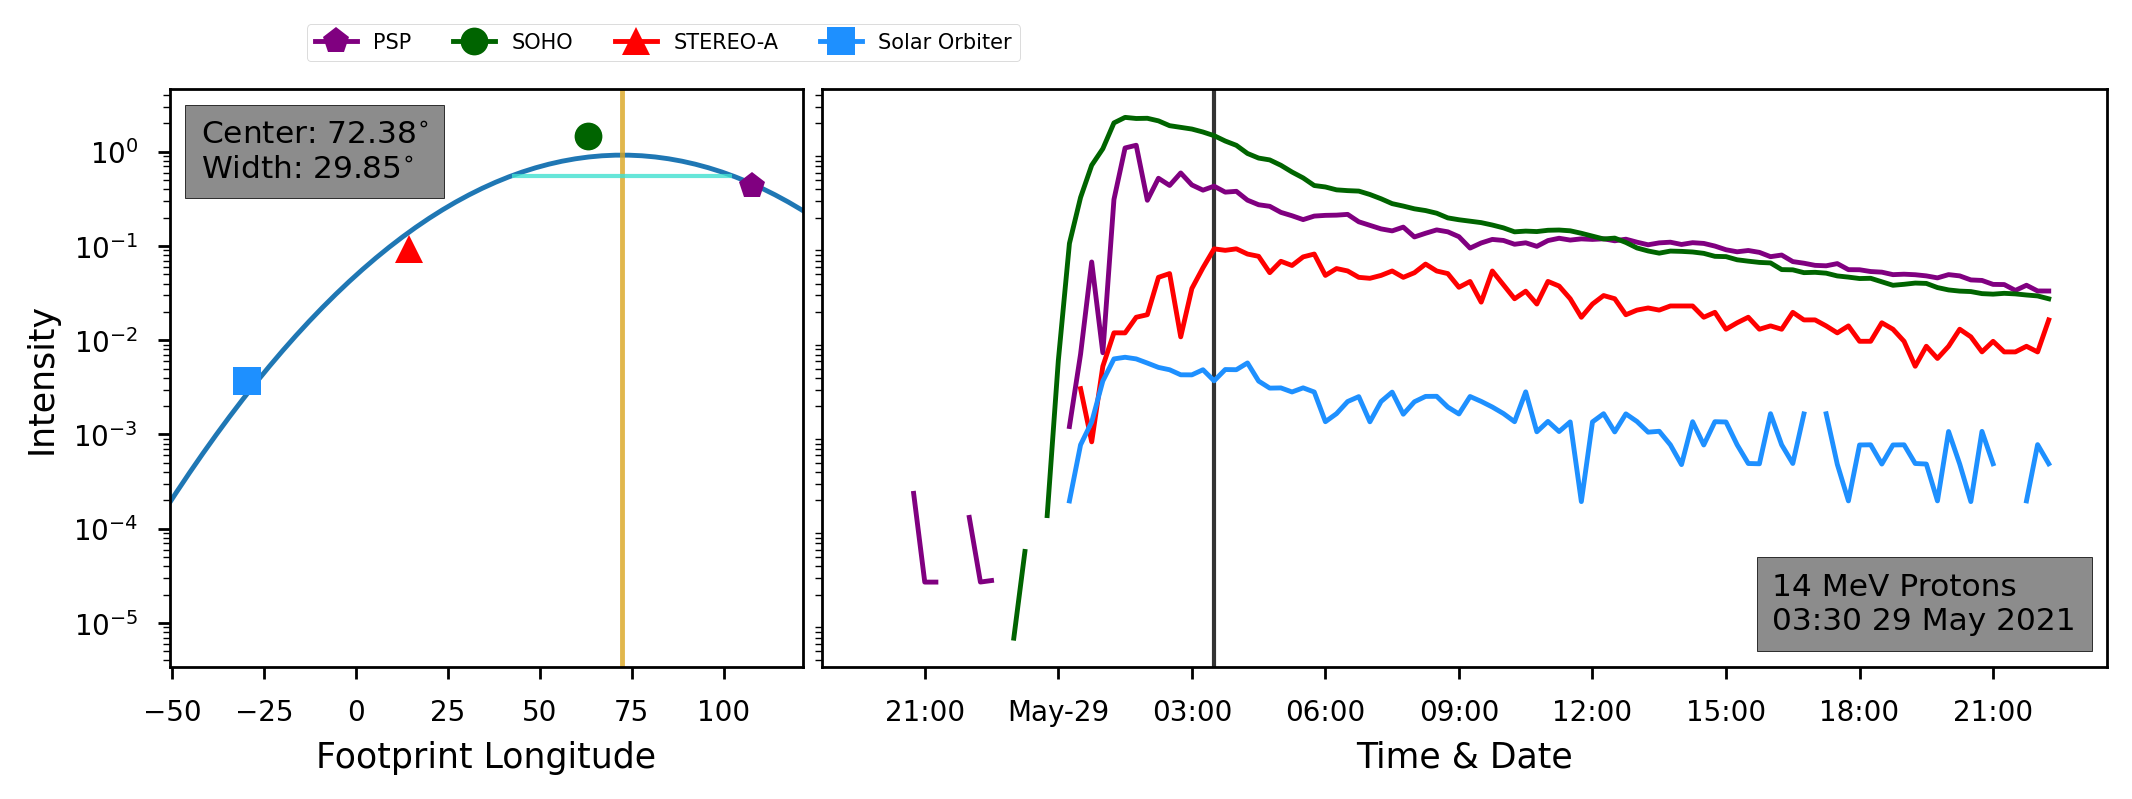
</div>

## Table of Contents
1. [Load the event](#Load-the-event)
2. [Background Subtraction](#Background-Subtraction)
3. [Instrument Intercalibration](#Instrument-Intercalibration)
4. [Radial Scaling](#Radial-Scaling)
5. [Peak Fits](#Peak-Fits)
6. [Gaussian Fits](#Gaussian-Fits)
7. [Final Results](#Final-Results)
- [Appendix](#Appendix)
- [Glossary](#Glossary)

In [1]:
# Import modules
import os
import datetime as dt
import numpy as np
import pandas as pd
from solarmach import SolarMACH

from JTL_SEP_functions import SEPEvent

## Load the event
[Return to top](#Table-of-Contents)

Collect the event start and end dates (specifying the start at / near the observed flare onset time), and the eruption location (in Stonyhurst).

In [2]:
# Options
event_options = {'28May2021': {'date': "2021/05/28 22:19:00",
                               'reference': [67, 18]},
                 '29Mar2025': {'date': "2025/03/29 00:30:00",
                               'reference': [np.nan, np.nan]},
                 '04Jan2025': {'date': "2025/01/04 18:27:00",
                               'reference': [60, -15]},
                 '17Dec2024': {'date': "2024/12/17 12:53:00",
                               'reference': [33, -16]},
                 '08Dec2024': {'date': "2024/12/08 08:50:00",
                               'reference': [52, -6]},
                 '03Oct2024': {'date': "2024/10/03 12:08:00",
                               'reference': [8, -15]},
                 '01Sep2024': {'date': "2024/09/01 14:44:00",
                               'reference': [66, -12]},
                 '22Jul2024': {'date': "2024/07/22 22:30:00",
                               'reference': [np.nan, np.nan]},
                 '23Mar2024': {'date': "2024/03/23 00:58:00",
                               'reference': [-15, -14]},
                 '29Jan2024': {'date': "2024/01/29 03:54:00",
                               'reference': [86, 28]},
                 '28Sep2021': {'date': "2021/09/28 05:54:00",
                               'reference': [36, -26]}}

startdate = dt.datetime.strptime(event_options['28May2021']['date'], "%Y/%m/%d %H:%M:%S")
enddate = startdate + pd.Timedelta(days=1)

source_location = event_options['28May2021']['reference'] #longitude, latitude


### Show the fleet distribution
For more information on the Solar-MACH tool, see: [the Online Tool](https://solar-mach.github.io/) and the links within.

NB: If you wish to use BepiColombo data then it will need to downloaded separately and saved to the same folder.

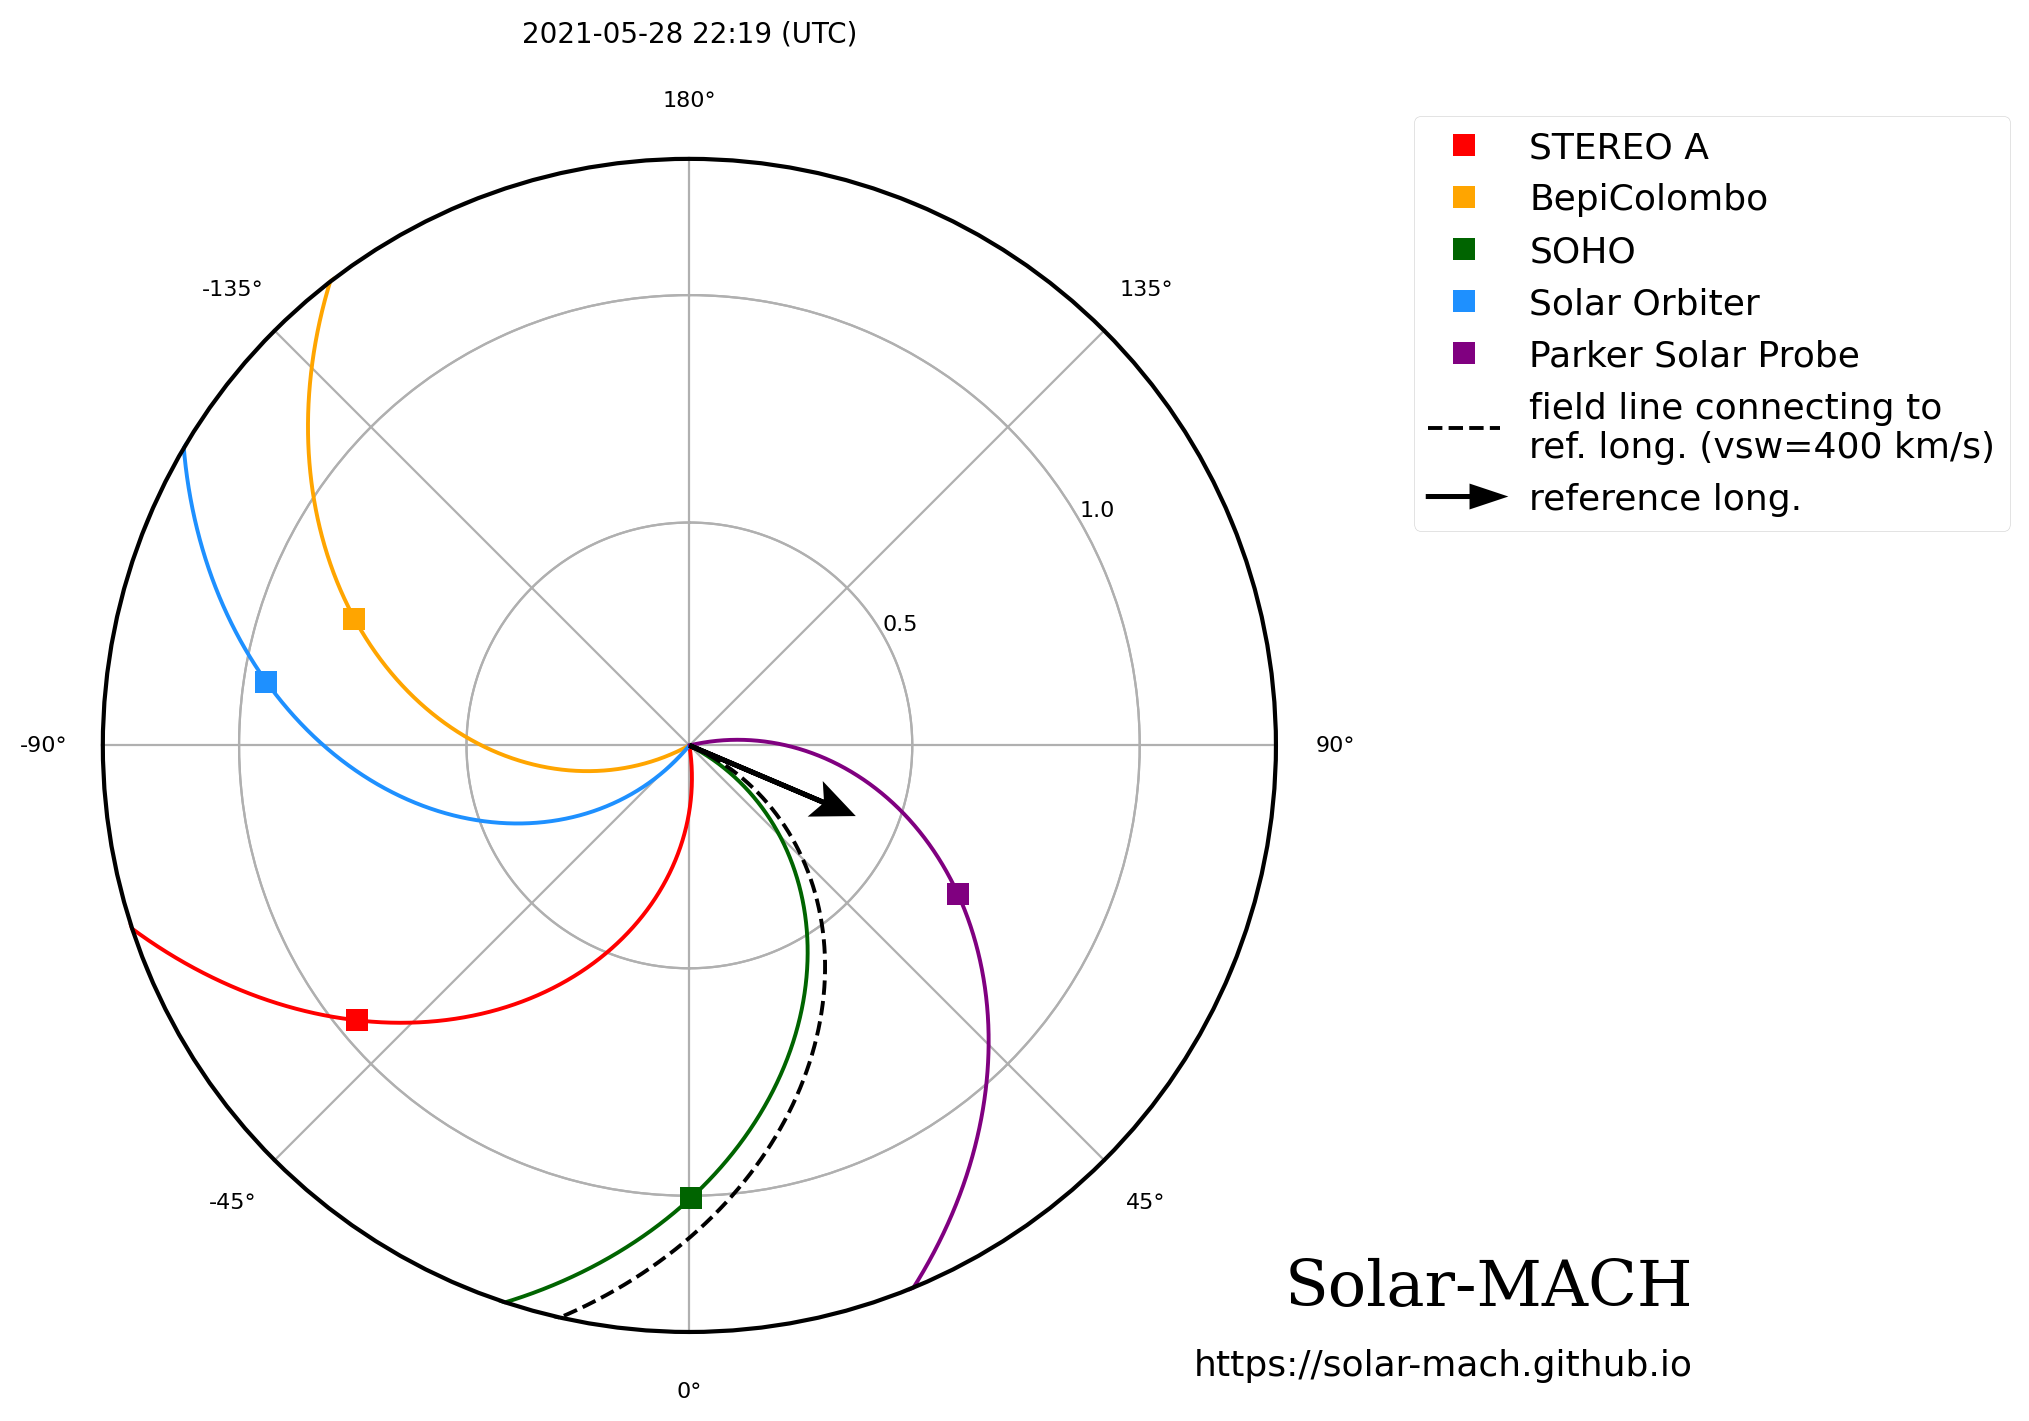

In [3]:
sm = SolarMACH(startdate, ['STEREO-A', 'BepiColombo', 'SOHO', 'Solar Orbiter', 'PSP'], vsw_list=[400]*5, 
              reference_long=source_location[0], reference_lat=source_location[1], coord_sys='Stonyhurst')

sm.plot()

In [4]:
display(sm.coord_table)

,Spacecraft/Body,Stonyhurst longitude (°),Stonyhurst latitude (°),Heliocentric distance (AU),Longitudinal separation to Earth's longitude,Latitudinal separation to Earth's latitude,Vsw,Magnetic footpoint longitude (Stonyhurst),Longitudinal separation between body and reference_long,Longitudinal separation between body's magnetic footpoint and reference_long,Latitudinal separation between body and reference_lat
0,STEREO-A,-50.395401,-6.234611,0.963644,-50.395399,-5.197760,400,9.300427,-117.395401,-57.699573,-24.234611
1,BepiColombo,-110.733366,-3.410311,0.798805,-110.733364,-2.373459,400,-61.011138,-177.733366,-128.011138,-21.410311
2,SOHO,0.255711,-1.010817,1.004046,0.255714,0.026034,400,62.969437,-66.744289,-4.030563,-19.010817
3,Solar Orbiter,-98.578091,-0.943589,0.950952,-98.578089,0.093263,400,-39.194394,-165.578091,-106.194394,-18.943589
4,PSP,61.059695,3.108280,0.685340,61.059698,4.145132,400,103.695701,-5.940305,36.695701,-14.891720


### Spacecraft options

List the spacecraft you want to use in this notebook, the proton energy channels for each instrument, and the time interval you wish to use (resampling).

The default channels provided are for ~14 MeV protons.

More information about this step can be found in the [Appendix](#Appendix).

<div class="alert alert-block alert-warning">
<b>Notes for Nina:</b> Do we give them the list of all energy channels to be able to choose?
</div>

In [5]:
# ~14 MeV Proton channels
spacecraft_channels = {'PSP': [3,4],
                       'SOHO': [0],
                       'STEREO-A': [0],
                       'Solar Orbiter': [10,12]}

resampling = '15min'

In [6]:
# Set your local path where you want to save the output files. 
# If run on the project's JupyterHub server, set it to a common data folder. 
out_path = f"{os.getcwd()}{os.sep}SEP_Distribution/" # For the figures
data_path = f"{os.getcwd()}{os.sep}data/" # For the raw cdf 

<div class="alert alert-block alert-warning">
<b>Notes for Jan:</b> Could you please turn off the warnings from the data loaders?
</div>

<div class="alert alert-block alert-info">
<b>Note for user:</b> This step can take a while. Feel free to refresh your coffee while you wait.
</div>

In [7]:
may282021 = SEPEvent(channels = spacecraft_channels, 
                     dates = [startdate, enddate], 
                     resampling = resampling,
                     data_paths = [out_path, data_path], 
                     coord_sys = 'Stonyhurst', 
                     flare_loc = source_location)

{'H_ENERGY': array([ 7.3360386,  8.72407  , 10.374725 , 12.337697 , 14.672077 ,
       17.44814  , 20.74945  , 24.675394 , 29.344154 , 34.89628  ,
       41.4989   , 49.35079  , 58.68831  , 69.79256  , 82.9978   ],
      dtype=float32), 'H_ENERGY_DELTAPLUS': array([0.66396827, 0.7895957 , 0.93899286, 1.116657  , 1.3279365 ,
       1.5791914 , 1.8779857 , 2.233314  , 2.655873  , 3.158383  ,
       3.7559714 , 4.466628  , 5.311746  , 6.316766  , 7.511943  ],
      dtype=float32), 'H_ENERGY_DELTAMINUS': array([0.60886157, 0.7240625 , 0.86106026, 1.023979  , 1.2177231 ,
       1.448125  , 1.7221205 , 2.047958  , 2.4354463 , 2.89625   ,
       3.444241  , 4.095916  , 4.8708925 , 5.7925    , 6.888482  ],
      dtype=float32), 'H_ENERGY_LABL': array(['  6.7 -   8.0 MeV', '  8.0 -   9.5 MeV', '  9.5 -  11.3 MeV',
       ' 11.3 -  13.5 MeV', ' 13.5 -  16.0 MeV', ' 16.0 -  19.0 MeV',
       ' 19.0 -  22.6 MeV', ' 22.6 -  26.9 MeV', ' 26.9 -  32.0 MeV',
       ' 32.0 -  38.1 MeV', ' 38.1 -  45.3 

/home/jaxl/Desktop/SOLER_SEPdistributiontool/JTL_SEP_functions.py:390: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(np.sum(x_arr**2)) / len(x_arr)


In [ ]:
may282021.get_peak_df()
may282021.plot_peak_fits()

Save the file?  


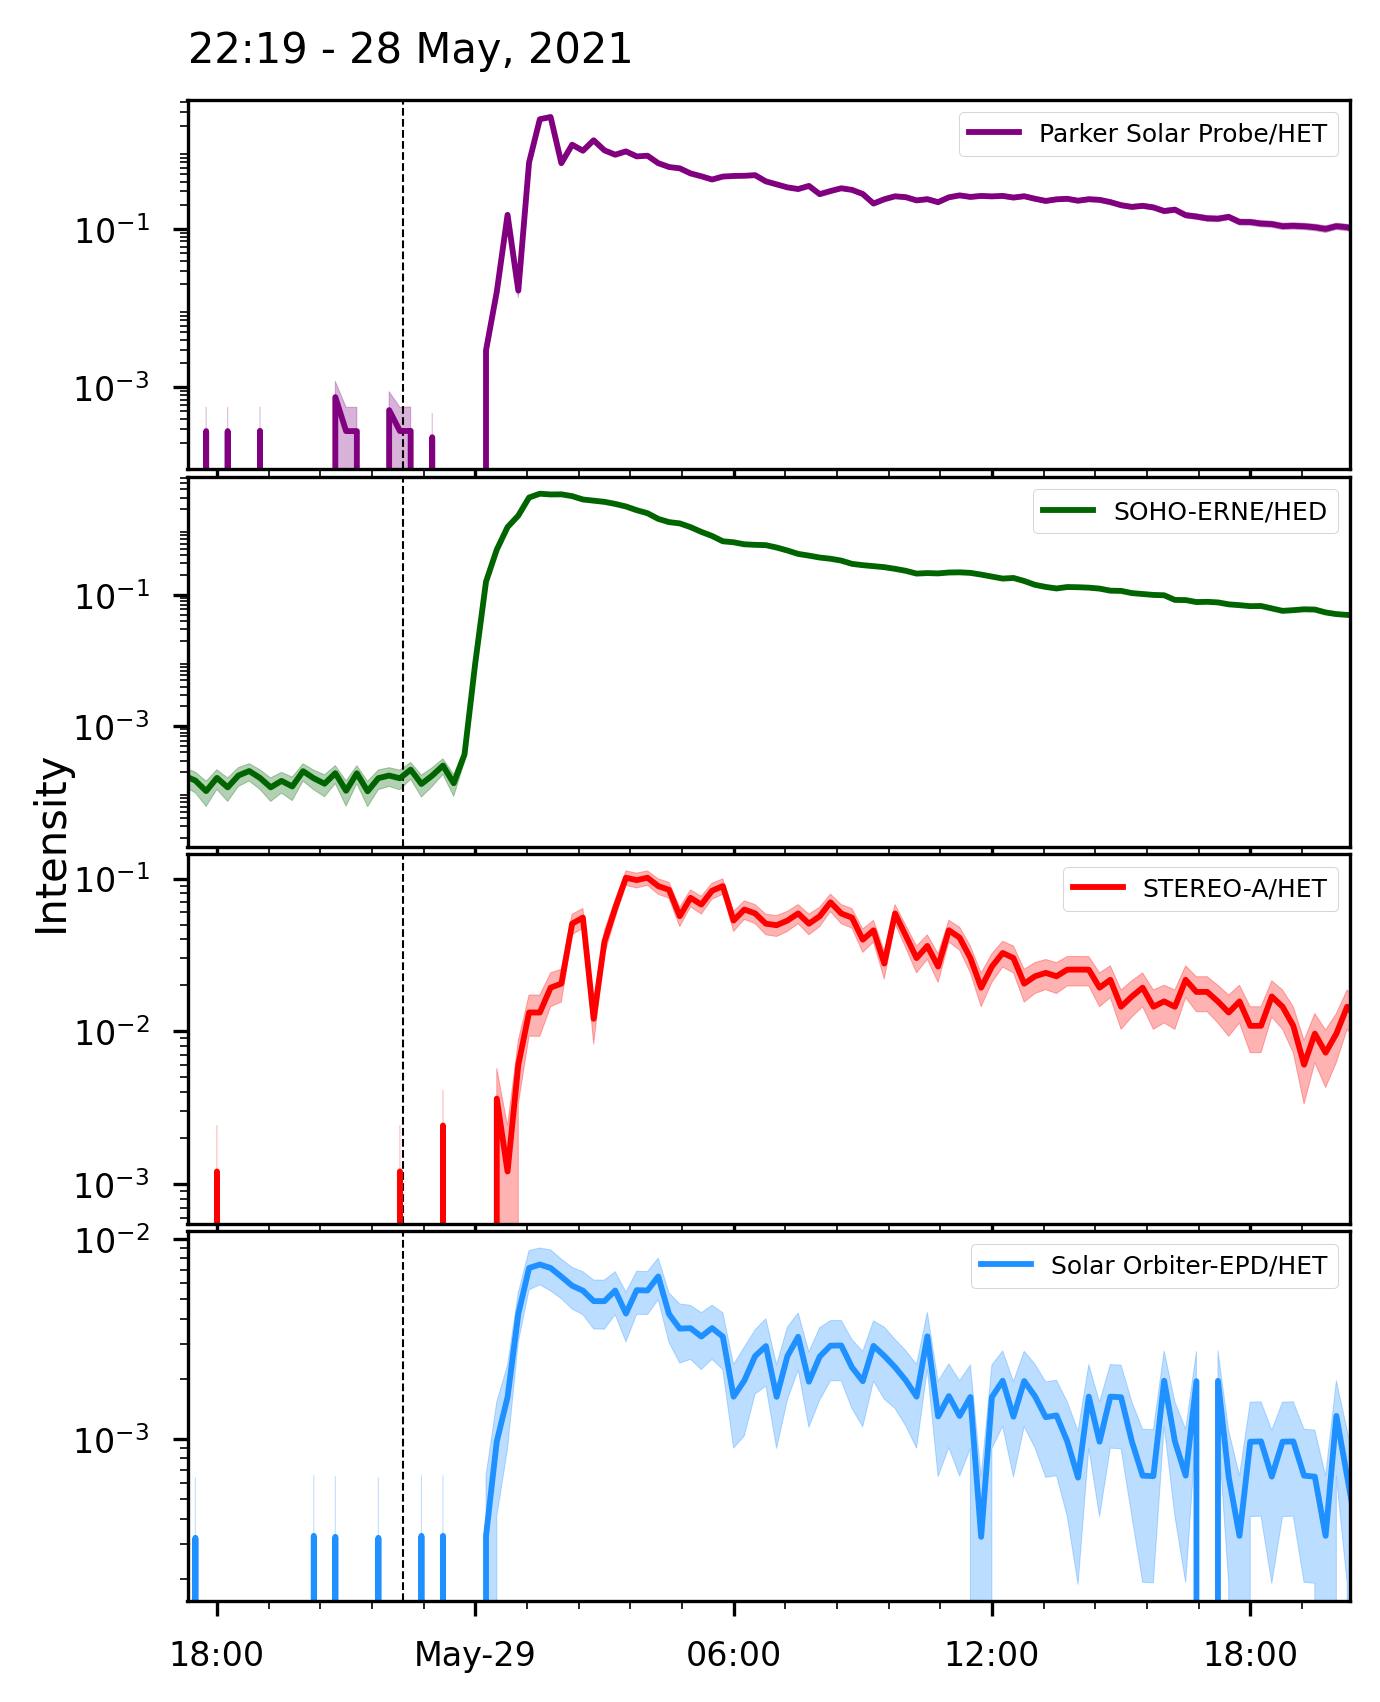

In [8]:
may282021.plot_intensities()

## Background Subtraction
[Return to top](#Table-of-Contents)

Plot time series of all instruments and let the user decide on a background window for each. Then background subtract it all.

More information about this step can be found in the [Appendix](#Appendix).

<div class="alert alert-block alert-danger">
<b>JAX:</b> Change this to allow each observer to have a unique window.
</div>

In [ ]:
# User input on background
background_window = [startdate-dt.timedelta(hours=2), startdate+dt.timedelta(minutes=60)]

# User can check the window
may282021.plot_intensities(background_window=background_window)

In [ ]:
# Perform the Background subtraction
may282021.background_subtract(background_window)

## Instrument Intercalibration
[Return to top](#Table-of-Contents)

This method adjusts the intensity data so as to calibrate each instrument to one common baseline. In this work, STEREO-A HET is the baseline and the only instrument that we have found (for this energy range and species) that requires an intercalibration factor is SOHO-ERNE/HED (see [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8) for more information).

More information about this step can be found in the [Appendix](#Appendix).

In [ ]:
ic_values = {'PSP':1, 
             'SOHO':0.67, 
             'STEREO-A':1, 
             'Solar Orbiter':1}

may282021.intercalibrate(intercalibration_values=ic_values)

## Radial Scaling
[Return to top](#Table-of-Contents)

This method adjusts the intensity data to 1~au from whatever radial distance the spacecraft is measuring at according to: $I_{1 au} = I \cdot R^{a\pm b}$.

The values provided are in the form of `[a, b]` from [Lario et al. (2006)](https://iopscience.iop.org/article/10.1086/508982).

More information about this step can be found in the [Appendix](#Appendix).

In [ ]:
radscaling_values = [2.14, 0.26] 

may282021.radial_scale(radial_scaling_factors=radscaling_values)


## Peak Fits
[Return to top](#Table-of-Contents)

Plot the fitted Gaussian to the peak intensity as a function of the footprint longitude of the spacecraft at the time of the peak.

<br>

`window_length`: Provide an estimate for how many hours can pass where the peak intensity might occur.
The window to consider the peak will then be considered between the given start time and (for e.g.) 5 hours later.

If nothing is provided, the function uses a default value of 10 hours.

In [ ]:
may282021.plot_peak_fits(window_length=5)

<div class="alert alert-block alert-danger">
<b>JAX:</b> Add a list of sc that aren't included in the calc but are still plotted in the end.
</div>

## Gaussian Fits
[Return to top](#Table-of-Contents)

A Gaussian curve is fitted to the observed intensities as a function of the observers footprint longitude at each time step.

More information about this step can be found in the [Appendix](#Appendix).

In [ ]:
may282021.calc_Gaussian_fit()

In [ ]:
# Test
may282021.get_sc_df('Gauss')

## Final Results
[Return to top](#Table-of-Contents)

<div class="alert alert-block alert-danger">
<b>JAX:</b> Legend should have the energy ranges.
</div>

In [ ]:
may282021.plot_gauss_results()

## Appendix
[Return to top](#Table-of-Contents)

### Load the data
In this method, we are downloading the spacecraft's positional data using SolarMACH and the intensity (and intensity uncertainty) data for the given proton energy channels (in this notebook the range is approximately 12-16 MeV).

If a range of channels is provided then they are merged using a weighted sum method, before averaging the data to 15-minute intervals (resampling).

### Background Subtraction

Calculates the average intensity value of the background time period and reduces the full dataset by this value.

### Intercalibration

This method adjusts the intensity data so as to calibrate each instrument to one common baseline. In this work, STEREO-A HET is the baseline and the only instrument that we have found (for this energy range and species) that requires an intercalibration factor is SOHO-ERNE/HED (see [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8) for more information).

### Radial Scaling

Using the values presented in [Farwa, et al. (2025)](https://www.aanda.org/articles/aa/abs/2025/01/aa50945-24/aa50945-24.html), which used values for 4-13 MeV and 27-37 MeV protons from [Lario et al. (2006)](https://iopscience.iop.org/article/10.1086/508982) (for ~100 keV electrons, [Rodríguez-García et al. (2023)](https://www.aanda.org/10.1051/0004-6361/202244553) is used).

The scaled intensity is calculated as $I_{1 au} = I \cdot R^{a\pm b}$, where $R$ is the radial distance, $I$ is the original intensity, and (for protons specifically) the scaling factors are given as $a \pm b = 2.14 \pm 0.26$ (or for 27-37 MeV protons: $a \pm b = 1.97 \pm 0.27$).

To calculate the scaled uncertainty, we use the following procedure:
1. Calculate the boundary limits for the intensity calculation (e.g. $I_+ = I\cdot R^{a+b}$; $I_- = I\cdot R^{a-b}$; Therefore, $\Delta I_+ = |I_{1 au}-I_+|$ and $\Delta I_- = |I_{1 au}-I_-|$ are the limits.
2. Find the higher boundary limit, as long as it is < the nominal value ($I_{1 au}$).
3. Calculate the scaled uncertainty value: $\Delta I_{1 au} = \Delta I \cdot R^a$.
4. Combine both to get a final uncertainty value: $\Delta I_{1 au, final} = \sqrt{(max[\Delta I_-, \Delta I_+])^2 + (\Delta I_{1 au})^2}$.

NB: Check that this final uncertainty is still less than the intensity value!

### Gaussian Curve Fitting

To calculate the Gaussian curve we use $f = A \cdot \exp\left[ \frac{-(x - X_0)^2}{2 \sigma^2} \right]$ where $A$ is the height of the curve, $X_0$ is the center of the curve, and $\sigma$ is the 'width' of the curve. In order to plot these values on the curve (i.e. straight lines at the center etc) the sigma value is plotted with `y = (0.6065) 10^{A}`, `xmin = X_0 - sigma`, and `xmax = X_0 + sigma`.

The logarithmic Gaussian curve is calculated with the same variables using $f = \log A - \frac{(x - X_0)^2}{2 \ln(10) \sigma^2}.$

The example in the figure uses the following parameters: $A=100, X_0=50,$ and $\sigma=20$.

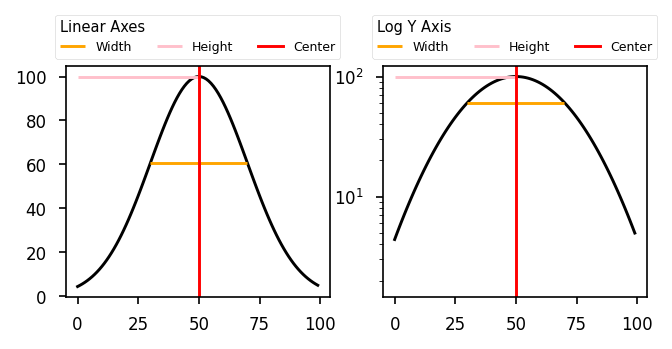

## Glossary
[Return to top](#Table-of-Contents)

- `*.get_sc_df('sc')`
  Returns the data for the given spacecraft (`sc`) or if provided `'Gauss'` then it will return the results of fitting the Gaussian curve.
- `*.plot_intensities()`
  Plots the intensity time series of all the provided spacecraft. Can also pass the keyword argument: `background_window=[start, end]` with start and end dates to provide a highlighted region in the plot.